## Analysis of ReAct and LLM-DP Alfworld data

In [23]:
import glob
import json
files = glob.glob('output/*.json')
data = []
for file in files:
    with open(file, 'r') as f:
        filename = file.split('/')[-1].split('.')[0].split('_')[0]
        new_data = json.loads(f.read())
        if len(new_data) != 134:
            print(f"Expected 134 examples, got {len(new_data)} for {file}")
            continue
        for example in new_data:
            example['run_name'] = filename
            if "llmdp" in filename:
                sample_size = file.split('/')[-1].split('.')[0].split('_')[1]
                example['sample_size'] = int(sample_size)
            else:
                example['sample_size'] = 0
            seed = file.split('/')[-1].split('.')[0].split('_')[-1]
            example['seed'] = seed

            data.append(example)
        

In [24]:
import pandas as pd

df = pd.DataFrame(data)
df["success"] = df["success"].astype(int)
df["name"] = df["run_name"]

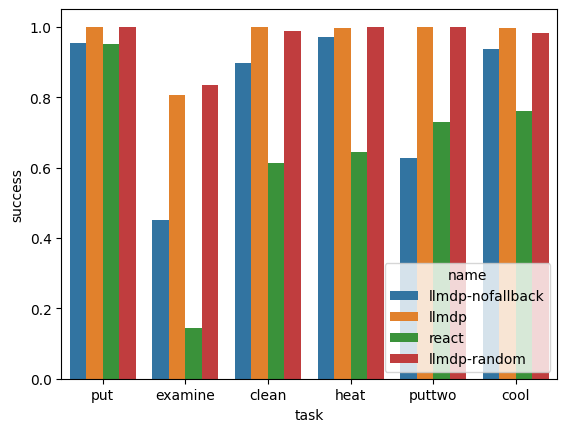

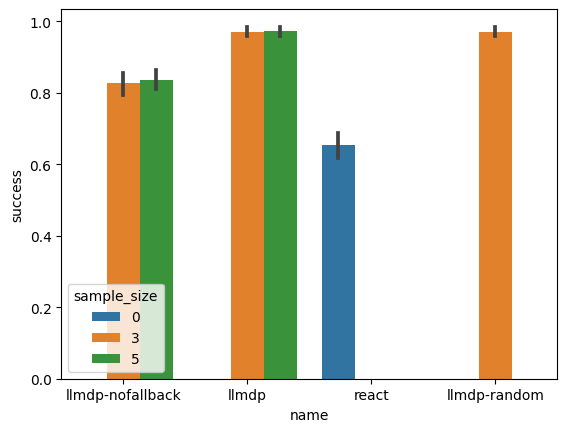

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="task", y="success", hue="name",
              data=df, errwidth=0)
plt.show()

sns.barplot(y="success", x="name", hue="sample_size",
            data=df)
plt.show()

### Table 1a

In [40]:
no_fallback = df[(df["name"] != "llmdp-nofallback") & (df["sample_size"] <= 3)]


# Latex table
tmp = no_fallback.groupby(["name", "task"]).success.agg(["mean"])
# rotate index
tmp = tmp.unstack().swaplevel(axis=1).sort_index(axis=1, level=0)
tmp.columns = tmp.columns.droplevel(1)
tmp = tmp.reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")

cols =  ["clean", "cool", "examine", "heat", "put", "puttwo"]
# tmp["overall (std)"] = df.groupby(["name"]).success.agg(["mean"]).reset_index(drop=False)["mean"]
tmp["overall"]  = no_fallback.groupby(["name", "seed"]).success.mean().reset_index(drop=False).groupby("name").success.mean().values
# calculate std
std = no_fallback.groupby(["name", "seed"]).success.mean().reset_index(drop=False).groupby("name").success.std()

tmp["overall"] = tmp["overall"].apply(lambda x: f"{x:.2f}") + " (" + std.apply(lambda x: f"{x:.2f}").values + ")"


tmp["llm tokens"] = no_fallback.groupby(["name", "seed"]).llm_tokens.sum().reset_index(drop=False).groupby("name").llm_tokens.mean().values
tmp["llm tokens"] = tmp["llm tokens"].apply(lambda x: f"{x:.0f}")

# std for llm tokens
std = no_fallback.groupby(["name", "seed"]).llm_tokens.sum().reset_index(drop=False).groupby("name").llm_tokens.std()
tmp["llm tokens"] = tmp["llm tokens"] + " (" + std.apply(lambda x: f"{x:.2f}").values + ")"


# print(df.groupby(["run_name"]).success.agg(["std"]).reset_index(drop=False)["std"])
# format to % all columns except name
tmp = tmp.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
# tmp.columns = ["name"] + [f"{n} (\%)" for n in tmp.columns if n != "name"] 
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lllllllll}
\toprule
                 name & clean & cool & examine & heat &  put & puttwo &     overall &           llm tokens \\
\midrule
       \textbackslash texttt\{llmdp\} &  1.00 & 1.00 &    0.80 & 0.99 & 1.00 &   1.00 & 0.97 (0.00) &    702075 (16243.56) \\
\textbackslash texttt\{llmdp-random\} &  0.99 & 0.98 &    0.83 & 1.00 & 1.00 &   1.00 & 0.97 (0.01) &         67108 (6.12) \\
       \textbackslash texttt\{react\} &  0.61 & 0.76 &    0.14 & 0.64 & 0.95 &   0.73 & 0.65 (0.02) & 6925489 (3313328.95) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1448223/4173351673.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tmp.to_latex(index=False, float_format="%.2f"))


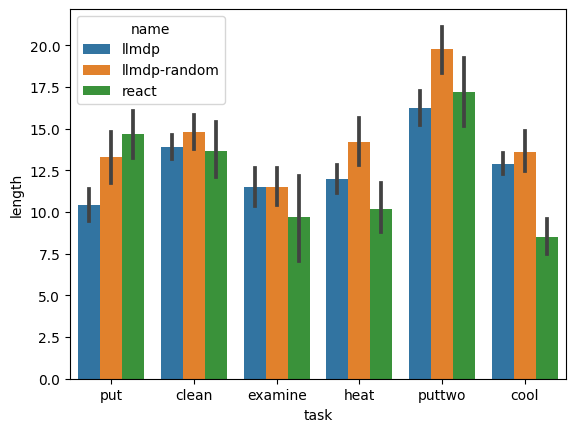

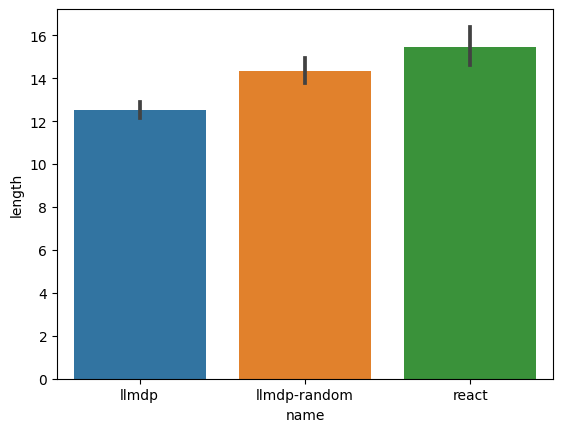

In [41]:
order = ["llmdp", "llmdp-random", "react"]
sns.barplot(x="task", y="length", hue="name", data=df[df.success == 1], hue_order=order)
plt.show()

sns.barplot(y="length", x="name", order=order,
              data=df)
plt.show()

### Table 1b

In [46]:
# Latex table
tmp = no_fallback.groupby(["name", "task"]).length.agg(["mean"])
# rotate index
tmp = tmp.unstack().swaplevel(axis=1).sort_index(axis=1, level=0)
tmp.columns = tmp.columns.droplevel(1)
tmp = tmp.reset_index(drop=False)
tmp.name = tmp.name.apply(lambda x: "\\texttt{" + x + "}")

cols =  ["clean", "cool", "examine", "heat", "put", "puttwo"]
tmp["overall"] = no_fallback.groupby(["name"]).length.agg(["mean"]).reset_index(drop=False)["mean"]

# std for overall length
std = no_fallback.groupby("name").length.agg(["std"]).reset_index(drop=False)["std"]
tmp["overall"] = tmp["overall"].apply(lambda x: f"{x:.2f}") + " (" + std.apply(lambda x: f"{x:.2f}").values + ")"

# format to % all columns except name
tmp = tmp.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)
tmp.columns = ["name"] + [f"{n}" for n in tmp.columns if n != "name"] 
print(tmp.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{llllllll}
\toprule
                 name & clean &  cool & examine &  heat &   put & puttwo &       overall \\
\midrule
       \textbackslash texttt\{llmdp\} & 13.85 & 13.25 &    9.46 & 12.18 & 10.43 &  15.91 &  12.53 (7.11) \\
\textbackslash texttt\{llmdp-random\} & 15.25 & 13.97 &    9.77 & 14.19 & 13.27 &  19.75 &  14.35 (7.71) \\
       \textbackslash texttt\{react\} & 15.78 & 11.57 &   19.64 & 13.35 & 15.61 &  17.95 & 15.47 (12.38) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1448223/1651936925.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tmp.to_latex(index=False, float_format="%.2f"))
